# German Traffic Sign Exploration

## Downloading the Data
go to [this](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html)
page and download the `GTSRB_Final_Training_Images.zip` dataset. Unzip the folder and move its contents into the root of the project. The unziped contents for me were a folder called `GTSRB` with a subfolder `Final_Training` and a text file.
The code below relies on this folder structure so if your folders are called something different, change the `DATA_DIR` and `TRAINING_DATA_PATH` constants.

## Setting up Virtual Environment
To install the required packages in a virtual environment use this command
``` shell
python3 -m venv env
source env/bin/activate
pip3 install -r requirements.txt
```

## Useful Links
* [Convolutional Neural Network Example](https://github.com/Navkrish04/German-Traffic-Sign-Classification/blob/master/German_Traffic_Data_Final_v1.ipynb)
* [Another Example](https://colab.research.google.com/github/frogermcs/GTSRB-TensorFlow-Lite/blob/master/notebooks/GTSRB_TensorFlow_MobileNet.ipynb#scrollTo=yI3kuswNS1tB)
* [yet another](https://towardsdatascience.com/classification-of-traffic-signs-with-lenet-5-cnn-cb861289bd62)

In [1]:
# STDLIB
import os
import typing
import csv
# Packages
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_memory_growth(gpus[1], True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# your code

Num GPUs Available:  2


2022-05-11 15:49:53.863376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 15:49:53.863630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 15:49:53.868450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 15:49:53.868682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 15:49:53.868967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## Constants

In [2]:
DATA_DIR = "GTSRB"
TRAINING_DATA_PATH = os.path.join(DATA_DIR, "Final_Training/Images")

In [3]:
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        with open(prefix + 'GT-'+ format(c, '05d') + '.csv') as gtFile:
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            next(gtReader) # skip header
            # loop over all images in current annotations file
            for row in gtReader:
                image = cv.imread(prefix + row[0]) # read image, the 1th column is the filename
                image = cv.resize(image, (32,32)) # resize to 32x32
                # image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # convert to grayscale
                images.append(image)
                labels.append(row[7]) # the 8th column is the label
    return images, labels



raw_images, raw_labels = readTrafficSigns(TRAINING_DATA_PATH)

def process_images(images):
    output = []
    for image in images:
        output.append(cv.resize(image, (32,32))) # resize to 32x32
    return output

processed_images = process_images(raw_images)
# convert the list to numpy arrays
images = np.array(processed_images).astype(np.float32) # this allows us to convert it to a tensor
images = images/255 # Everyone seems to do this so we will too!!!
labels = np.array(raw_labels).astype(np.float32)
assert len(images) == len(labels)



Number of images:  39209
Number of classes:  43
(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42)


<BarContainer object of 43 artists>

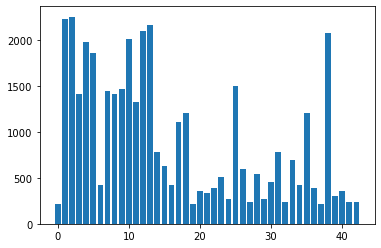

In [4]:
print("Number of images: ", len(images)) # should be 39209
classes, counts = np.unique(labels, return_counts=True)
print("Number of classes: ", len(classes)) # should be 43
# Plot the number of images in each class
# convert classes and counts from strings to numbers
classes = list(map(int, classes))
countscounts = list(map(int,counts))
classes, counts = zip(*sorted(zip(classes, counts)))
print(classes)
plt.bar(classes, counts)

## Distribution
We can see that the data is not evenly distributed between the different classes. This may be important later.

Traffic Sign Images


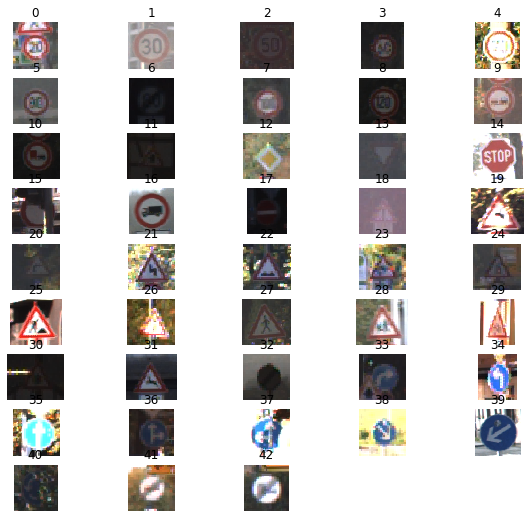

In [5]:
# View few images
def getImageFromEachClass(rootpath):
    '''Gets one image from each of the 42 classes

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        with open(prefix + 'GT-'+ format(c, '05d') + '.csv') as gtFile:
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            next(gtReader) # skip header
            # Get one image from the class
            images.append(plt.imread(prefix + next(gtReader)[0])) # the 1th column is the filename
    return images

%matplotlib inline
print("Traffic Sign Images")
plt.figure(figsize=(10, 10))
unique_images = getImageFromEachClass(TRAINING_DATA_PATH)
for i, unique_image in enumerate(unique_images):
    plt.subplot(10,5, i + 1)
    plt.axis('off')
    plt.imshow(unique_image)
    plt.title(str(i))

From the Tensorflow [docs](https://www.tensorflow.org/tutorials/images/cnn)
The lines of code below define the convolutional base using a common pattern: 
a stack of Conv2D and MaxPooling2D layers. To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification.

In [6]:
## Here we are using a convolutional Neural Network for classification

## This design was taken from the Keras documentation
model = keras.models.Sequential()
## These layers are for feature extraction
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
## This is the densly connected layer that will aid in classification
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(43)) # Number of classes
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

2022-05-11 15:49:55.257719: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-11 15:49:55.335138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 15:49:55.335327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 15:49:55.335468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [7]:
# Check to see if we have already trained the model
MODEL_NAME = "basic_cnn.h5"
    
if os.path.exists(MODEL_NAME):
    print("Loading existing model. If you want to retrain, delete the file: " + MODEL_NAME)
    model = keras.models.load_model(MODEL_NAME)
else:
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=123)

    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    history = model.fit(train_images, train_labels, epochs=20, 
                        validation_data=(test_images, test_labels))

    # summarize history for accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    ## After plotting, lets save the model to a HDF5 file
    model.save(MODEL_NAME)

Loading existing model. If you want to retrain, delete the file: basic_cnn.h5


## Testing
Now that we have trained our model on the training data, lets see how it does on the official test data

On the website, the test images are in the `GTSRB_Final_Test_Images.zip` link. This set is formatted 
slightly different from the Training images so we will use a new function to read them into numpy arrays.

Additionally, the images do not have ground truth values (classes) associated with them. To get these, we have to
download the `GTSRB_Final_Test_GT.zip` link and extract a `.csv` file. We will move this `.csv` file into the `Final_Test`
folder from the extracted test image zip. 

In [8]:
TEST_DATA_PATH = os.path.join(DATA_DIR, "Final_Test/Images")

def readTrafficSignsTest(rootpath: str):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    with open(os.path.join(rootpath, 'GT-final_test.csv')) as gtFile:
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            file_link = os.path.join(rootpath, row[0])
            image = cv.imread(file_link) # read image, the 1th column is the filename
            # image = cv.resize(image, (32,32)) # resize to 32x32
            # image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # convert to grayscale
            images.append(image)
            labels.append(row[7]) # the 8th column is the label
    return images, labels

def run_model_on_data(model: keras.Model, images, labels):
    """_summary_: Runs the model on the given images and labels.

    Args:
        model (keras.Model): The model to run on the images.
        images (list[cv.Mat]): The images to run on. These should already be processed.
        labels (list[str]): The labels to run on.

    Returns:
        A dictionary with two keys: 'accuracy' and 'loss'.
    """
    test_images = np.array(images).astype(np.float32) # this allows us to convert it to a tensor
    test_images = test_images/255 # Everyone seems to do this so we will too!!!
    test_labels = np.array(labels).astype(np.float32)

    assert len(test_images) == len(test_labels)

    result = model.evaluate(test_images, test_labels)
    return dict(zip(model.metrics_names, result))


real_test_images, real_test_labels = readTrafficSignsTest(TEST_DATA_PATH)
processed_test_images = process_images(real_test_images)

result_dict = run_model_on_data(model, processed_test_images, real_test_labels)
print(result_dict)

2022-05-11 15:49:56.531289: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


395/395 [==============================] - 1s 2ms/step - loss: 0.4926 - accuracy: 0.9455
{'loss': 0.49262526631355286, 'accuracy': 0.9455265402793884}


In running this model, we saw around a $94$% accuracy. Results may vary depending on the data chosen for the test/train split.
## Changes to the model
We will try to implement some changes to the model to 

In [9]:

def get_model():
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
    return model


# Check to see if we have already trained the model
MODEL_NAME = "cnn_v2.h5"

model = get_model()
if os.path.exists(MODEL_NAME):
    print("Loading existing model. If you want to retrain, delete the file: " + MODEL_NAME)
    model = keras.models.load_model(MODEL_NAME)
else:
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=True),
                  metrics=['accuracy'])
    history = model.fit(train_images, train_labels, epochs=20,
                        validation_data=(test_images, test_labels))

    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # After plotting, lets save the model to a HDF5 file
    model.save(MODEL_NAME)

Loading existing model. If you want to retrain, delete the file: cnn_v2.h5


In [10]:
result_dict = run_model_on_data(model, processed_test_images, real_test_labels)
print(result_dict)

 45/395 [==>...........................] - ETA: 0s - loss: 0.1501 - accuracy: 0.9729   

/home/trex/.local/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


395/395 [==============================] - 1s 2ms/step - loss: 0.1770 - accuracy: 0.9734
{'loss': 0.17702029645442963, 'accuracy': 0.9733966588973999}


This new model had a prediction accuracy of $97.8%$.

The next steps will be to experiment with the hyper parameters. Insiration was taken from the [Keras_tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)
webpage.

In [11]:
import keras_tuner as kt
def get_model(hp):
    model = keras.models.Sequential()
    hp_convolution_activation = hp.Choice('convolution_activation', ['relu', 'sigmoid', 'tanh'])
    
    model.add(Conv2D(32, (3, 3), activation=hp_convolution_activation, input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation=hp_convolution_activation, input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    hp_max_pool_size = hp.Choice('max_pool_size', [2, 3, 4])
    model.add(MaxPooling2D(pool_size=(hp_max_pool_size, hp_max_pool_size)))
    hp_droput_rate_1 = hp.Choice('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    model.add(Dropout(hp_droput_rate_1))
    model.add(Flatten())
    hp_dense_units = hp.Int('dense1_units', min_value=32, max_value=1024, step=32)
    model.add(Dense(hp_dense_units, activation='relu'))
    hp_droput_rate_2 = hp.Choice('dropout_rate2', [0.25, 0.5, 0.6])
    model.add(Dropout(hp_droput_rate_2))
    model.add(Dense(43, activation='softmax'))
    # Compile the model
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

tuner = kt.Hyperband(get_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='Final_Project')

# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=123)
tuner.search(train_images, train_labels, epochs=20, validation_data=(test_images, test_labels), callbacks=[stop_early])


INFO:tensorflow:Reloading Oracle from existing project my_dir/Final_Project/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/Final_Project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [12]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
variable_params = [
    'convolution_activation',
    'max_pool_size',
    'dropout_rate',
    'dense1_units',
    # 'dropout_rate2',
]

for i in range(len(variable_params)):
    print(variable_params[i] + ": " + str(best_hps[variable_params[i]]))


convolution_activation: tanh
max_pool_size: 3
dropout_rate: 0.3
dense1_units: 256


### Results from Tuning
* convolution_activation: relu
* max_pool_size: 2
* dropout_rate: 0.3
* dense1_units: 800
* dropout_rate: 0.3
* dropout_rate2: 0.5

Now, we we retrain the model with these new hyperparameters with more epochs

In [13]:
def get_model():
    model = keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(800, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
    return model


# Check to see if we have already trained the model
MODEL_NAME = "cnn_v3.h5"

model = get_model()
if os.path.exists(MODEL_NAME):
    print("Loading existing model. If you want to retrain, delete the file: " + MODEL_NAME)
    model = keras.models.load_model(MODEL_NAME)
else:
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=True),
                  metrics=['accuracy'])
    history = model.fit(train_images, train_labels, epochs=30,
                        validation_data=(test_images, test_labels))

    # summarize history for accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # After plotting, lets save the model to a HDF5 file
    model.save(MODEL_NAME)

Loading existing model. If you want to retrain, delete the file: cnn_v3.h5


In [14]:
result_dict = run_model_on_data(model, processed_test_images, real_test_labels)
print(result_dict)

395/395 [==============================] - 1s 2ms/step - loss: 0.1384 - accuracy: 0.9762
{'loss': 0.1384381502866745, 'accuracy': 0.9762470126152039}



## Results From Evaluation
We have achieved a prediction accuracy of around $97$% on the test set.

## Image Deformations and Their Results on Classification Accuracy

Now we will look at some different ways our input image could arrive deformed and how we can correct for this 
defformation

### Motion Blur

We will start with motion blur. This is essentially when the image appears "smeared" due to data being captured
using a moving camera

process is taken from [this](https://en.wikipedia.org/wiki/Unsharp_masking#Digital_unsharp_masking) Wikipedia page
and [this](https://stackoverflow.com/questions/4993082/how-can-i-sharpen-an-image-in-opencv) stack overflow post

1) Process 1 is Gaussian Sharpening 
2) Process 2 is basically just applying a convolution matrix or mask. See [here](https://en.wikipedia.org/wiki/Kernel_(image_processing))

Different Gaussian Sharpening Sigma Values


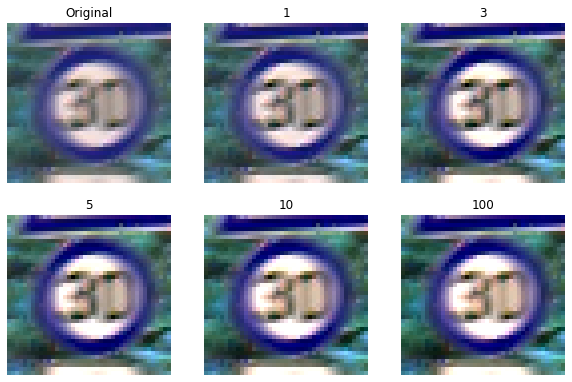

In [15]:
# In order to prevent motion blur, we will use the gaussian sharpen filter
'''Applies gaussian sharpen filter to an image.

    Arguments: image to be processed, sigma for the gaussian filter
    Returns:   processed image'''
def gaussian_sharpen(image: cv.Mat, sigma: float = 10) -> cv.Mat:
    """_summary_: Applies gaussian sharpen filter to an image.

    Args:
        image (cv.Mat): The image to be processed.
        sigma (float, optional): The sigma value to be passed to the Gaussian Blur Funtion. Defaults to 3.

    Returns:
        cv.Mat: The processed image.
    """
    blurred_image = cv.GaussianBlur(image, (0,0), sigma)
    return cv.addWeighted(image, 1.5, blurred_image, -0.5, 0)

sigma_vals = [1, 3, 5, 10, 100]
image_index = 110
print("Different Gaussian Sharpening Sigma Values")
plt.figure(figsize=(10, 10))
plt.subplot(3,3,1)
plt.axis('off')
plt.imshow(real_test_images[image_index])
plt.title("Original")
for i, sigma in enumerate(sigma_vals):
    plt.subplot(3,3, i + 2)
    plt.axis('off')
    plt.imshow(gaussian_sharpen(real_test_images[image_index], sigma=sigma))
    plt.title(str(sigma))


Different Gaussian Sharpening Sigma Values


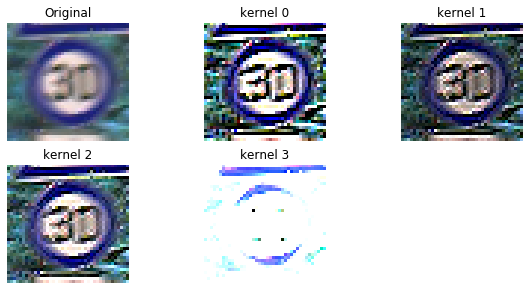

In [16]:
# We will experiment with another way to sharpen the image
# This is a simple kernel filter

kernels = [
    np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]),
    np.array([[0,-1,0], [-1,4.7,-1], [0,-1,0]]),
    np.array([[0,-1,0], [-1,5,-1], [0,-1,0]]),
    np.array([[0,-1,0], [-1,9,-1], [0,-1,0]]),
]

image_index = 110
print("Different Gaussian Sharpening Sigma Values")
plt.figure(figsize=(10, 10))
plt.subplot(4,3,1)
plt.axis('off')
plt.imshow(real_test_images[image_index])
plt.title("Original")
for i, kernel in enumerate(kernels):
    plt.subplot(4,3, i + 2)
    plt.axis('off')
    plt.imshow(cv.filter2D(real_test_images[image_index], -1, kernel))
    plt.title("kernel " + str(i))



From the output images, it looks like the best sharpening is achieved by using Gaussian Sharpening 
with a high sigma value (>10).

Now, we will use this image sharpening in our image processing step to see if it impacts our classification
accuracy.

In [17]:

# Define a new process_image function that uses the gaussian sharpen filter
def process_images_new(images):
    output = []
    for image in images:
        output.append(cv.resize(image, (32,32))) # resize to 32x32
        image = gaussian_sharpen(image)
    return output

processed_test_images = process_images_new(real_test_images)

print(type(processed_test_images[110]))

result_dict = run_model_on_data(model, processed_test_images, real_test_labels)
print(result_dict)

<class 'numpy.ndarray'>
395/395 [==============================] - 1s 2ms/step - loss: 0.1384 - accuracy: 0.9762
{'loss': 0.1384381502866745, 'accuracy': 0.9762470126152039}


### Sharpening Results

It does not appear that sharpening the input image has any affect on classification accuracy.
**The next thing to try would be to retrain the model using this image processing method.**

### Fast Gradient Sign Method

Attack on standard model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


395/395 [==============================] - 2s 5ms/step - loss: 4.1075 - accuracy: 0.5845
{'loss': 4.107461929321289, 'accuracy': 0.584481418132782}


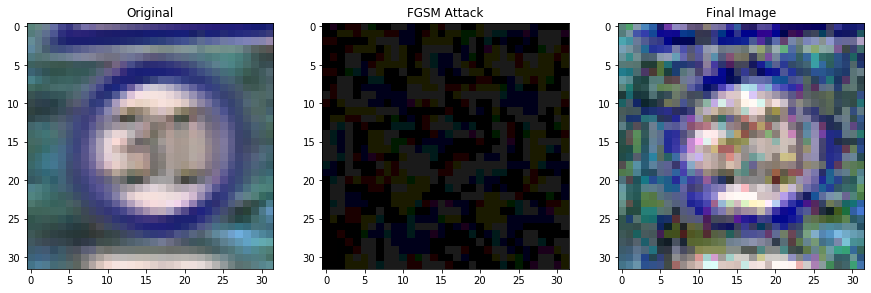

In [55]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

def convert_types(images):
    output = []
    for image in images:
#         print(type(image))
        image = cv.resize(image,(32,32))
        image = tf.cast(image, tf.float32)
        image /= 127.5
        image -= 1.0
        output.append(image)
    return output

def convert_image(tensors):
    output = []
    for tensor in tensors:
        tensor += 1.0
        tensor *= 127.5
        image = tensor.numpy()
#         print(np.shape(image))
        image = cv.resize(image,(32,32))
        image = image.astype(int)
#         print(np.shape(image))
        output.append(image)
    return output

with tf.device('/CPU:0'):
    num = len(real_test_images)#5000
    data = convert_types(real_test_images)
#     print(type(real_test_images[image_index]))
#     print(type(data[image_index]))
    eps = 0.2
    
    test_fgsms = fast_gradient_method(model, data, eps, np.inf)
    test_fgsms = convert_image(test_fgsms)
        
#     print(type(test_fgsms))
#     print(np.shape(test_fgsms[image_index]))
#     print(np.shape(real_test_images[image_index]))
#     print(cv.resize(real_test_images[image_index],(32,32))-test_fgsms[image_index])
    
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1,3,1)
#     plt.axis('off')
    
    im_num = image_index
    
#     print("FGSM Attacked Images")
#     plt.figure(figsize=(10, 10))
#     plt.subplot(1,3,1)
#     plt.axis('off')
    plt.imshow((cv.resize(real_test_images[image_index],(32,32))).astype(int))
    plt.title("Original")
    
#     plt.figure(figsize=(10, 10))
    plt.subplot(1,3,2)
#     plt.axis('off')
    plt.imshow((cv.resize(real_test_images[image_index],(32,32))-test_fgsms[im_num]).astype(int))
    plt.title("FGSM Attack")
    
#     plt.figure(figsize=(10, 10))
    plt.subplot(1,3,3)
#     plt.axis('off')
    plt.imshow((test_fgsms[im_num]).astype(int))
    plt.title("Final Image")
    
    result_fgsm = run_model_on_data(model, test_fgsms, real_test_labels)
    print(result_fgsm)
    
#     print(cv.resize(real_test_images[image_index],(32,32)))
#     print(test_fgsms[im_num])